Loading neccesary packages and prepping the Palmer Penquins data.

In [3]:
import warnings
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

np.set_printoptions(precision = 3)
plt.style.use('seaborn-v0_8-whitegrid')

url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/palmer-penguins/train.csv"
df = pd.read_csv(url)

# Shorten the species name
df["Species"] = df["Species"].str.split().str.get(0)

# filter our data so it only contains the variables we will look at first
# look at the first 5 entries to determine variables that seem as if they could have a correlation
df.head()

,studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Comments
0,PAL0809,31,Chinstrap,Anvers,Dream,"Adult, 1 Egg Stage",N63A1,Yes,11/24/08,40.9,16.6,187.0,3200.0,FEMALE,9.08458,-24.54903,NaN
1,PAL0809,41,Chinstrap,Anvers,Dream,"Adult, 1 Egg Stage",N74A1,Yes,11/24/08,49.0,19.5,210.0,3950.0,MALE,9.53262,-24.66867,NaN
2,PAL0708,4,Gentoo,Anvers,Biscoe,"Adult, 1 Egg Stage",N32A2,Yes,11/27/07,50.0,15.2,218.0,5700.0,MALE,8.25540,-25.40075,NaN
3,PAL0708,15,Gentoo,Anvers,Biscoe,"Adult, 1 Egg Stage",N38A1,Yes,12/3/07,45.8,14.6,210.0,4200.0,FEMALE,7.79958,-25.62618,NaN
4,PAL0809,34,Chinstrap,Anvers,Dream,"Adult, 1 Egg Stage",N65A2,Yes,11/24/08,51.0,18.8,203.0,4100.0,MALE,9.23196,-24.17282,NaN


In [66]:
df.groupby(["Island", "Species"]).size()

Island     Species  
Biscoe     Adelie       33
           Gentoo       98
Dream      Adelie       45
           Chinstrap    57
Torgersen  Adelie       42
dtype: int64

Torgersen Island is home exclusively to Adelie penguins, while Dream Island is the only habitat for Chinstrap penguins, despite an almost equal distribution of Adelie and Chinstrap there. Biscoe Island hosts primarily Gentoo penguins, making up 74.8% of its population. While Adelie penguins are found on all islands, each island has a degree of exclusivity in species distribution. This is a semi promising indicator. 

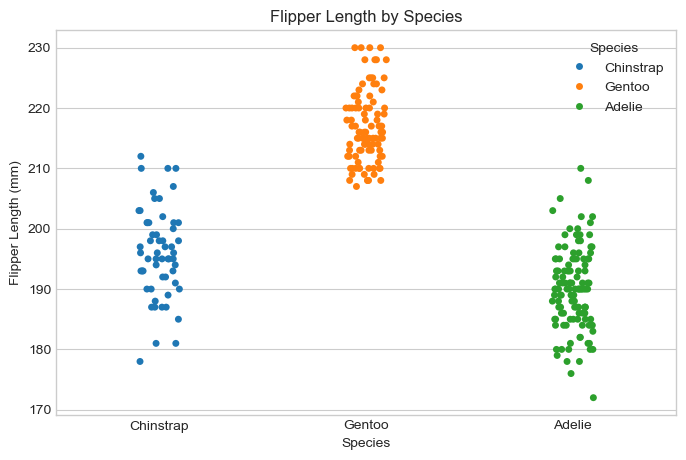

In [67]:
# explore the species groups by flipper length
plt.figure(figsize=(8, 5))
sns.stripplot(x = "Species", y = "Flipper Length (mm)", data = df, hue = "Species", legend = "brief")
plt.title("Flipper Length by Species")
plt.show()

Grouping by species and analyzing flipper length clearly distinguishes Gentoo penguins, as they generally have longer flippers than Chinstrap and Adelie penguins. However, flipper length is not a reliable identifier between Chinstrap and Adelie penguins, as their ranges overlap significantly.

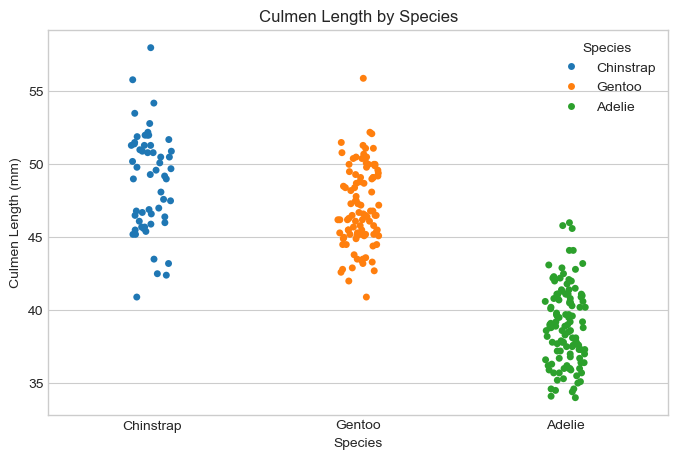

In [68]:
# explore the species groups by culmen length
plt.figure(figsize=(8, 5))
sns.stripplot(x = "Species", y = "Culmen Length (mm)", data = df, hue = "Species", legend = "brief")
plt.title("Culmen Length by Species")
plt.show()

While there is not a clear distinction between Culmen Length for Chinstrap and Gentoo penquins, there is a clear separation the two species from Adelie. This means that Culmen Length could be used as an indicator for Chinstrap penquins, in combination with island identity. 

Next we will define a method to properly give integer values to species as well as other categorical variables and apply this method to our data. 

In [69]:
from sklearn.preprocessing import LabelEncoder

# Selecting relevant columns
df1 = df[["Species", "Culmen Length (mm)", "Island", "Flipper Length (mm)"]]

# Initialize LabelEncoders for categorical variables
species_encoder = LabelEncoder()
island_encoder = LabelEncoder()

def prepare_data(df):
    df = df.dropna()
    
    # Encode categorical variables
    df["species_label"] = species_encoder.fit_transform(df["Species"])
    df["island_label"] = island_encoder.fit_transform(df["Island"])
    
    # Define target variable
    y = df["species_label"]
    
    return df, y

# Prepare data
full_train, y_train = prepare_data(df1)

C:\Users\miceo\AppData\Local\Temp\ipykernel_45480\1322769177.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["species_label"] = species_encoder.fit_transform(df["Species"])
C:\Users\miceo\AppData\Local\Temp\ipykernel_45480\1322769177.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["island_label"] = island_encoder.fit_transform(df["Island"])


Now to split our data into training and testing data

<Axes: xlabel='Culmen Length (mm)', ylabel='Flipper Length (mm)'>

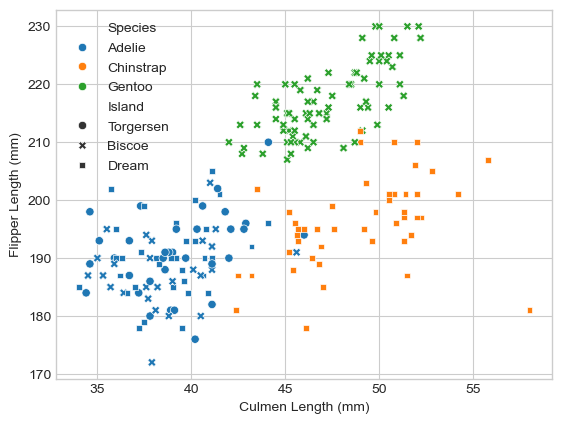

In [70]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(full_train, test_size = .2)

# Visualize our Training Data
sns.scatterplot(data = df_train, x = "Culmen Length (mm)", y = "Flipper Length (mm)", hue = "Species", style = "Island")

Gentoo penquins cluster very distinguishably in the upper right, whereas Chainstrap and Adelie penquins become harder to distinguish, especially as their island regions mix more. While a linear model may well, other models such as SVM may work better. A linear regression will be fitted first.

In [71]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC # support vector classifier

predictor_cols = ["Culmen Length (mm)", "Flipper Length (mm)", "island_label"]
target_col = "species_label"

X_train = df_train[predictor_cols]
y_train = df_train[target_col]

X_test = df_test[predictor_cols]
y_test = df_test[target_col]

LR = LogisticRegression(max_iter = 1000)
m = LR.fit(X_train, y_train)

Time to check the training accuracy of the model and cross validate. 

In [72]:
from sklearn.model_selection import cross_val_score

print(LR.score(X_train, y_train))

cv_scores_LR = cross_val_score(LR, X_train, y_train, cv = 5)
print(cv_scores_LR)


0.9678899082568807
[0.955 1.    0.909 0.977 0.953]


Plot the decision regions for the model against the training data.

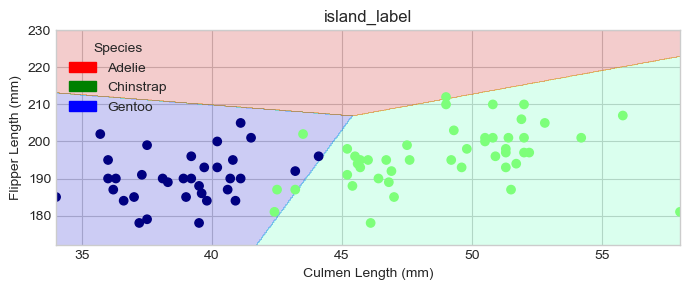

0.9636363636363636


In [73]:
from matplotlib.patches import Patch

def plot_regions(model, X, y):
    
    x0 = X[X.columns[0]]
    x1 = X[X.columns[1]]
    qual_features = X.columns[2:]
    
    fig, axarr = plt.subplots(1, len(qual_features), figsize = (7, 3))

    # Ensure axarr is always a list-like object
    if len(qual_features) == 1:
      axarr = [axarr]

    # create a grid
    grid_x = np.linspace(x0.min(),x0.max(),501)
    grid_y = np.linspace(x1.min(),x1.max(),501)
    xx, yy = np.meshgrid(grid_x, grid_y)
    
    XX = xx.ravel()
    YY = yy.ravel()

    for i in range(len(qual_features)):
      XY = pd.DataFrame({
          X.columns[0] : XX,
          X.columns[1] : YY
      })

      for j in qual_features:
        XY[j] = 0

      XY[qual_features[i]] = 1

      p = model.predict(XY)
      p = p.reshape(xx.shape)
      
      
      # use contour plot to visualize the predictions
      axarr[i].contourf(xx, yy, p, cmap = "jet", alpha = 0.2, vmin = 0, vmax = 2)
      
      ix = X[qual_features[i]] == 1
      # plot the data
      axarr[i].scatter(x0[ix], x1[ix], c = y[ix], cmap = "jet", vmin = 0, vmax = 2)
      
      axarr[i].set(xlabel = X.columns[0], 
            ylabel  = X.columns[1], 
            title = qual_features[i])
      
      patches = []
      for color, spec in zip(["red", "green", "blue"], ["Adelie", "Chinstrap", "Gentoo"]):
        patches.append(Patch(color = color, label = spec))

      plt.legend(title = "Species", handles = patches, loc = "best")
      
      plt.tight_layout()
      plt.show()

plot_regions(LR, X_train[predictor_cols], y_train)

# Check the model accuracy against the testing data
print(LR.score(X_test, y_test))

Linear regression with the current parameters did not result in a 100% testing accuracy. Lets try switching out our qualitative parameter to clutch completion.

In [53]:
df2 = df[["Species", "Culmen Length (mm)", "Clutch Completion", "Flipper Length (mm)"]]

# Initialize LabelEncoders for categorical variables
species_encoder = LabelEncoder()
clutch_encoder = LabelEncoder()

def prepare_data(df):
    df = df.dropna()
    
    # Encode categorical variables
    df["species_label"] = species_encoder.fit_transform(df["Species"])
    df["clutch_label"] = clutch_encoder.fit_transform(df["Clutch Completion"])
    
    # Define target variable
    y = df["species_label"]
    
    return df, y

full_train2, y_train2 = prepare_data(df2)

C:\Users\miceo\AppData\Local\Temp\ipykernel_45480\1614244165.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["species_label"] = species_encoder.fit_transform(df["Species"])
C:\Users\miceo\AppData\Local\Temp\ipykernel_45480\1614244165.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["clutch_label"] = clutch_encoder.fit_transform(df["Clutch Completion"])


Let's visualize our new training data.

<Axes: xlabel='Culmen Length (mm)', ylabel='Flipper Length (mm)'>

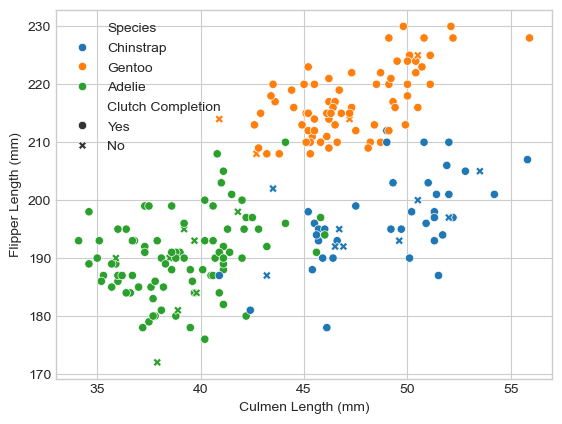

In [54]:
df_train2, df_test2 = train_test_split(full_train2, test_size = .2)

# Visualize our Training Data
sns.scatterplot(data = df_train2, x = "Culmen Length (mm)", y = "Flipper Length (mm)", hue = "Species", style = "Clutch Completion")

Time to fit the new Linear Regression Model. My guess is that this model may actually be less accurate than the model taking into account island, as clutch completion seems to be mixed more evenly between penquin species compared to origin island which had some degree of specification.

In [55]:
predictor_cols2 = ["Culmen Length (mm)", "Flipper Length (mm)", "clutch_label"]
target_col2 = "species_label"

X_train2 = df_train2[predictor_cols2]
y_train2 = df_train2[target_col2]

X_test2 = df_test2[predictor_cols2]
y_test2 = df_test2[target_col2]

LR2 = LogisticRegression(max_iter = 1000)
m2 = LR2.fit(X_train2, y_train2)

Check the new training accuracy and cross validate. Then look at the decision region for the new model.

0.9587155963302753
[0.932 0.932 0.977 0.953 0.953]


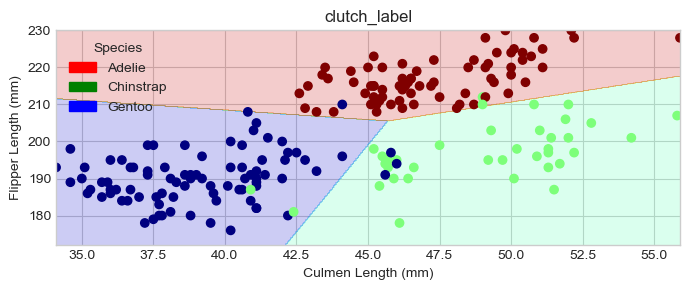

0.9818181818181818


In [56]:
print(LR2.score(X_train2, y_train2))

cv_scores_LR2 = cross_val_score(LR2, X_train2, y_train2, cv = 5)
print(cv_scores_LR2)

plot_regions(LR2, X_train2[predictor_cols2], y_train2)

# Check the model accuracy against the testing data
print(LR2.score(X_test2, y_test2))

Unfortunately, changing the qualitative indicator for this model actually decreased the testing accuracty of the model. Perhaps we should go back to the original qualitative indicator and change the quanitative indicators. Lets look at each quantitative indicator next to each other.

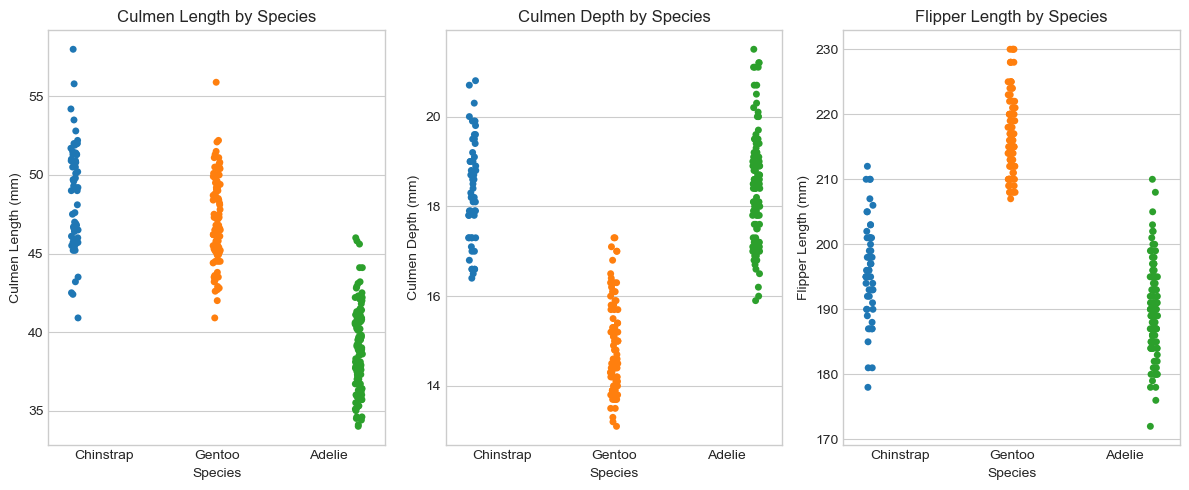

In [57]:
# explore the species groups by culmen length
fig, axes = plt.subplots(1, 3, figsize=(12, 5))

sns.stripplot(x = "Species", y = "Culmen Length (mm)", data = df, hue = "Species", ax = axes[0], dodge = True)
axes[0].set_title("Culmen Length by Species")

sns.stripplot(x = "Species", y = "Culmen Depth (mm)", data = df, hue = "Species", ax = axes[1], dodge = True, legend = False)
axes[1].set_title("Culmen Depth by Species")

sns.stripplot(x = "Species", y = "Flipper Length (mm)", data = df, hue = "Species", ax = axes[2], dodge = True, legend = False)
axes[2].set_title("Flipper Length by Species")

plt.tight_layout()
plt.show()

Looking at these plots side by side Culmen Depth and Flipper Length have almost inverse plots, perhaps these two in combination with Island would serve as a better model than with Culmen Length and Flipper Length. 

In [58]:
df3 = df[["Species", "Culmen Depth (mm)", "Island", "Flipper Length (mm)"]]

# Initialize LabelEncoders for categorical variables
species_encoder = LabelEncoder()
island_encoder = LabelEncoder()

def prepare_data(df):
    df = df.dropna()
    
    # Encode categorical variables
    df["species_label"] = species_encoder.fit_transform(df["Species"])
    df["island_label"] = island_encoder.fit_transform(df["Island"])
    
    # Define target variable
    y = df["species_label"]
    
    return df, y

full_train3, y_train3 = prepare_data(df3)

C:\Users\miceo\AppData\Local\Temp\ipykernel_45480\464828516.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["species_label"] = species_encoder.fit_transform(df["Species"])
C:\Users\miceo\AppData\Local\Temp\ipykernel_45480\464828516.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["island_label"] = island_encoder.fit_transform(df["Island"])


Visualize our third batch of training data

<Axes: xlabel='Culmen Depth (mm)', ylabel='Flipper Length (mm)'>

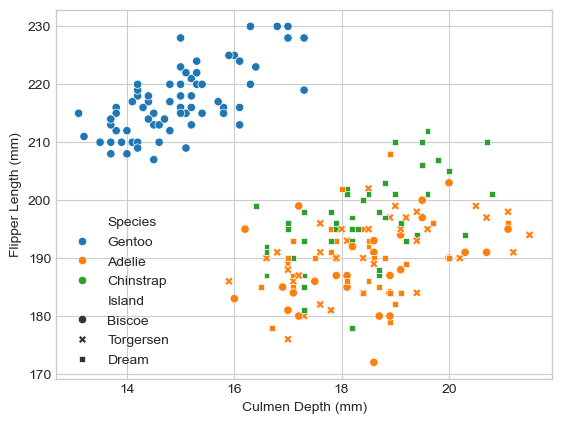

In [59]:
df_train3, df_test3 = train_test_split(full_train3, test_size = .2)

# Visualize our Training Data
sns.scatterplot(data = df_train3, x = "Culmen Depth (mm)", y = "Flipper Length (mm)", hue = "Species", style = "Island")

Visually there is a large separation between Gentoo and the other species, however there is almost no separation between Chinstrap and Adelie. I'll try a Linear Regression but a different ML model may be more appropriate. The separation of Gentoo is promising however. 

In [60]:
predictor_cols3 = ["Culmen Depth (mm)", "Flipper Length (mm)", "island_label"]
target_col3 = "species_label"

X_train3 = df_train3[predictor_cols3]
y_train3 = df_train3[target_col3]

X_test3 = df_test3[predictor_cols3]
y_test3 = df_test3[target_col3]

LR3 = LogisticRegression(max_iter = 1000)
m3 = LR3.fit(X_train3, y_train3)

Check the new training accuracy and cross validate. Then look at the decision region for the new model.

0.8302752293577982
[0.841 0.818 0.841 0.814 0.837]


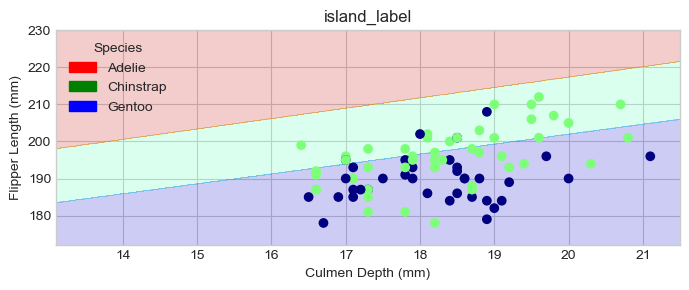

0.8181818181818182


In [61]:
print(LR3.score(X_train3, y_train3))

cv_scores_LR3 = cross_val_score(LR3, X_train3, y_train3, cv = 5)
print(cv_scores_LR3)

plot_regions(LR3, X_train3[predictor_cols3], y_train3)

# Check the model accuracy against the testing data
print(LR3.score(X_test3, y_test3))

Linear Regression clearly does not work for these parameters, however the clear separation between Gentoo is promising and other ML should be considered

0.9495412844036697
[0.818 0.864 0.795 0.814 0.837]


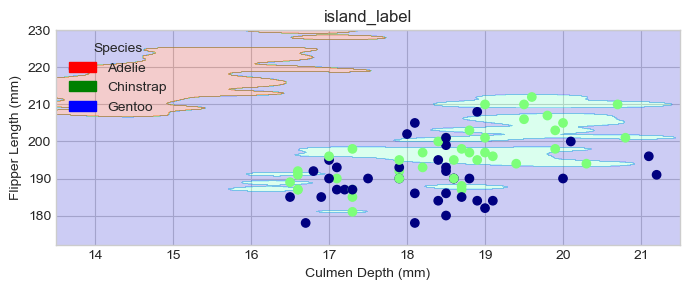

0.8


In [35]:
from sklearn.svm import SVC # support vector classifier

SVM = SVC(gamma = 1)
SVM.fit(X_train3, y_train3)

print(SVM.score(X_train3, y_train3))

cv_scores_SVM = cross_val_score(SVM, X_train3, y_train3, cv = 5)
print(cv_scores_LR3)

plot_regions(SVM, X_train3[predictor_cols3], y_train3)

# Check the model accuracy against the testing data
print(SVM.score(X_test3, y_test3))

Lets try a DecisionTree Classifier with out two datasets involving Island as our qualitative indicator as the SVM had a far worse accuracy for this dataset.

In [83]:
from sklearn.tree import DecisionTreeClassifier

reg1_1 = DecisionTreeClassifier(max_depth = 1)
reg1_5 = DecisionTreeClassifier(max_depth = 5)
reg2_1 = DecisionTreeClassifier(max_depth = 1)
reg2_5 = DecisionTreeClassifier(max_depth = 5)

# time to fit a decision tree classifier with depth 1 and 5 to both our datasets with Island as the qualitative indicator
reg1_1.fit(X_train, y_train)
reg1_5.fit(X_train, y_train)
reg2_1.fit(X_train3, y_train3)
reg2_5.fit(X_train3, y_train3)

# Check the training accuracy and cross validate each model
print("DecisionTreeClassifier with depth = 1 has a training accuracy of: " + str(reg1_1.score(X_train, y_train)) + " for dataset 1")

cv_reg1_1 = cross_val_score(reg1_1, X_train, y_train, cv = 5)
print("And a cross validation of: " + str(cv_reg1_1))

print("DecisionTreeClassifier with depth = 5 has a training accuracy of: " + str(reg1_5.score(X_train, y_train)) + " for dataset 1")

cv_reg1_5 = cross_val_score(reg1_5, X_train, y_train, cv = 5)
print("And a cross validation of: " + str(cv_reg1_5))

print("DecisionTreeClassifier with depth = 1 has a training accuracy of: " + str(reg2_1.score(X_train3, y_train3)) + " for dataset 3")

cv_reg2_1 = cross_val_score(reg2_1, X_train3, y_train3, cv = 5)
print("And a cross validation of: " + str(cv_reg2_1))

print("DecisionTreeClassifier with depth = 5 has a training accuracy of: " + str(reg2_5.score(X_train3, y_train3)) + " for dataset 3")

cv_reg2_5 = cross_val_score(reg2_5, X_train3, y_train3, cv = 5)
print("And a cross validation of: " + str(cv_reg2_5))



DecisionTreeClassifier with depth = 1 has a training accuracy of: 0.7844036697247706 for dataset 1
And a cross validation of: [0.795 0.773 0.773 0.767 0.791]
DecisionTreeClassifier with depth = 5 has a training accuracy of: 0.9908256880733946 for dataset 1
And a cross validation of: [0.932 0.977 0.932 0.977 1.   ]
DecisionTreeClassifier with depth = 1 has a training accuracy of: 0.7798165137614679 for dataset 3
And a cross validation of: [0.795 0.75  0.727 0.791 0.791]
DecisionTreeClassifier with depth = 5 has a training accuracy of: 0.908256880733945 for dataset 3
And a cross validation of: [0.909 0.818 0.886 0.744 0.837]


Based on training accuracy and cross validation model 2 (dataset 1 with depth = 5) seems to be the most promising. Lets check the decision region and accuracy against the testing data. 

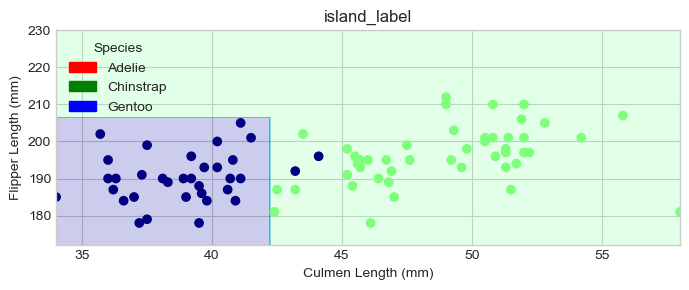

0.9454545454545454


In [84]:
plot_regions(reg1_5, X_train[predictor_cols], y_train)

# Check the model accuracy against the testing data
print(reg1_5.score(X_test, y_test))

Perhaps this model was overfit to the data. Lets examine the model with the second highest training accuracy (model 4: dataset 3 with depth  = 5).

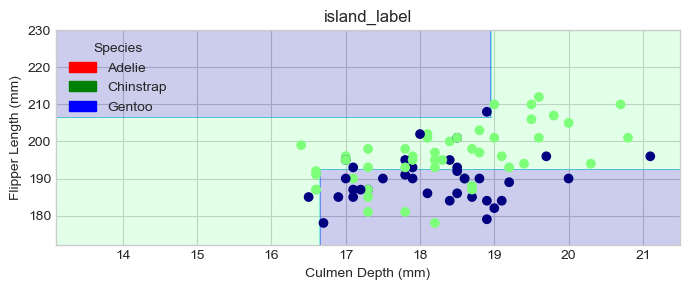

0.9090909090909091


In [86]:
plot_regions(reg2_5, X_train3[predictor_cols3], y_train3)

# Check the model accuracy against the testing data
print(reg2_5.score(X_test3, y_test3))